主要有两个部分：清洗数据与分析数据
分析数据时，计算了每个模型对于人工的的准确率、召回率、F1值、信度

In [ ]:
import pandas as pd
import json
import re
import pickle
import numpy as np

In [141]:
data=pd.read_excel('r1 revised（带人工答案）.xlsx')
def read_json(x):
    lst=[]
    for k,i in enumerate(x):
        i=i.replace("'",'"')
        try:
            lst.append(json.loads(i))
        except:
            print(str(k)+i)
    return lst
def read_jsonl(file_path):
    data = []
    # 以只读模式打开文件
    with open(file_path, 'r', encoding='utf-8') as file:
        # 逐行读取文件
        for line in file:
            try:
                # 尝试将每行内容解析为JSON对象
                json_obj = json.loads(line.replace('俄国','俄罗斯').replace('暹罗','泰国'))
                data.append(json_obj)
            except json.JSONDecodeError:
                # 如果解析失败，打印错误信息
                print(f"Failed to parse line: {line}")
    return data
data['人工']=read_json(data['人工'])

对jsonl文件（跟下面的不能一起用）：

In [158]:
readresult=read_jsonl(r'C:\Users\zz_cq\Documents\BaiduSyncdisk\code script\shenbao 2\gpt analysis\v3formaltest.jsonl')
sorted_data = sorted(readresult, key=lambda x: int(x['custom_id'].split('-')[1]))
rawtexts=[]
errors=[]
for k,i in enumerate(sorted_data):
    text=i['response']['body']['choices'][0]['message']['content'].replace("'", '"').replace('：', ':').replace('\n','').replace('‘','"').replace('’','"').replace('""','"')
    pattern1 = r'{(.*?)}'
    match = re.search(pattern1, text, re.DOTALL)
    if match:
        result = match.group(1)
    pattern2 = r'(\w+):'
    fixed_str1 = re.sub(pattern2, r'"\1":', result)
    pattern_value = r':\s*(?!\[)([^"\d\s][^,}]+)'
    fixed_str2 = re.sub(pattern_value, r': "\1"', fixed_str1)
    if fixed_str2[-1]!='"' and fixed_str2[-1]!=']':
        fixed_str2=fixed_str2+'"'
    outstr='{'+fixed_str2+'}'
    rawtexts.append(json.loads(outstr.replace('""','"')))

对pkl文件：

In [ ]:
rawtext=[]
#with open(r'C:\Users\zz_cq\seadrive_root\张潇逸 5220\我的资料库\私人资料库\code script\shenbao 2\gpt analysis\o1-2024-12-17.pkl','rb') as f:
#    rawtext=pickle.load(f)
with open(r'C:\Users\zz_cq\Documents\BaiduSyncdisk\code script\shenbao 2\gpt analysis\o1-2024-12-171.pkl','rb') as f:
    rawtext=pickle.load(f)
len(rawtext)
rawtexts=[]
for k,i in enumerate(rawtext):
    i=i.replace('Chile','智利').replace('China','中国').replace('England','英国').replace('France','法国').replace('Germany','德国').replace('Japan','日本').replace('Mexico','墨西哥').replace('Peru','秘鲁').replace('Spain','西班牙').replace('Russia','俄罗斯').replace('UK','英国').replace('USA','美国').replace('United Kingdom','英国').replace('韩国','朝鲜').replace('South Africa','南非')
    pattern1 = r'{(.*?)}'
    match = re.search(pattern1, i, re.DOTALL)
    if match:
        result = match.group(1)
    pattern2 = r'(\w+):'
    fixed_str1 = re.sub(pattern2, r'"\1":', result)
    pattern_value = r':\s*(?!\[)([^"\d\s][^,}]+)'
    fixed_str2 = re.sub(pattern_value, r': "\1"', fixed_str1)
    outstr='{'+fixed_str2+'}'
    rawtexts.append(json.loads(outstr.replace('""','"').replace('：',':')))


要去掉当时不存在的国家

In [159]:

countrylst=[]
for i in rawtexts:
    countrylst+=i['提到的国家']
countryset=set(countrylst)
noexsist=['以色列','匈奴','各国','埃及','巴比伦','希腊','欧洲','泰西各国','罗马','蒙古','西方','外洋',
          '哈萨克斯坦','外国','西洋','欧洲各国','欧洲国家','泰西（西方国家）','西方国家','南非','古希腊','古罗马','巴比伦(古国)','斐利息(古腓尼基)',
         '新加坡','香港','某国','Europe','Guatemala','Panama','Singapore','Western Countries']
cleantext=[]
for j in rawtexts:
    j['提到的国家']=list(i for i in j['提到的国家'] if i not in noexsist)
    cleantext.append(j)
countrylst=[]
for i in cleantext:
    countrylst+=i['提到的国家']
countryset=set(countrylst)


In [160]:
countrylst=[]
for i in rawtexts:
    countrylst+=i['提到的国家']
countryset=set(countrylst)
noexsist=['以色列','匈奴','各国','埃及','巴比伦','希腊','欧洲','泰西各国','罗马','蒙古','西方','外洋',
          '哈萨克斯坦','外国','西洋','欧洲各国','欧洲国家','泰西（西方国家）','西方国家','南非','古希腊','古罗马','巴比伦(古国)','斐利息(古腓尼基)',
         '新加坡','香港','某国','Europe','Guatemala','Panama','Singapore','Western Countries']
cleantext=[]
for j in rawtexts:
    j['提到的国家']=list(i for i in j['提到的国家'] if i not in noexsist)
    cleantext.append(j)
countrylst=[]
for i in cleantext:
    countrylst+=i['提到的国家']
countryset=set(countrylst)


In [161]:
sentimentlst=[]
for i in cleantext:
    new_data = {}
    for key, value in i.items():
        if any(country in key for country in i['提到的国家']) or key in ['提到的国家', '类别']:
            new_data[key] = value
    sentimentlst.append(new_data)
data['info']=sentimentlst
data['国家识别_gpt']=data['info'].apply(lambda x:set(x['提到的国家']))
data['国家识别_人工']=data['人工'].apply(lambda x:set(x['提到的国家']))
data['国家识别验证']=data['国家识别_gpt']==data['国家识别_人工']
data['国家识别验证'].describe()

count      100
unique       2
top       True
freq        82
Name: 国家识别验证, dtype: object

In [162]:
def calculate_precision(machine, human):
    """
    计算精确率
    """
    total_precision = 0
    valid_rows = 0
    for m, h in zip(machine, human):
        if len(m) == 0:
            continue
        correct_count = len(m.intersection(h))
        precision = correct_count / len(m)
        total_precision += precision
        valid_rows += 1
    if valid_rows == 0:
        return 0
    return total_precision / valid_rows


def calculate_recall(machine, human):
    """
    计算召回率
    """
    total_recall = 0
    valid_rows = 0
    for m, h in zip(machine, human):
        if len(h) == 0:
            continue
        correct_count = len(m.intersection(h))
        recall = correct_count / len(h)
        total_recall += recall
        valid_rows += 1
    if valid_rows == 0:
        return 0
    return total_recall / valid_rows


def calculate_f1(precision, recall):
    """
    计算 F1 分数
    """
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

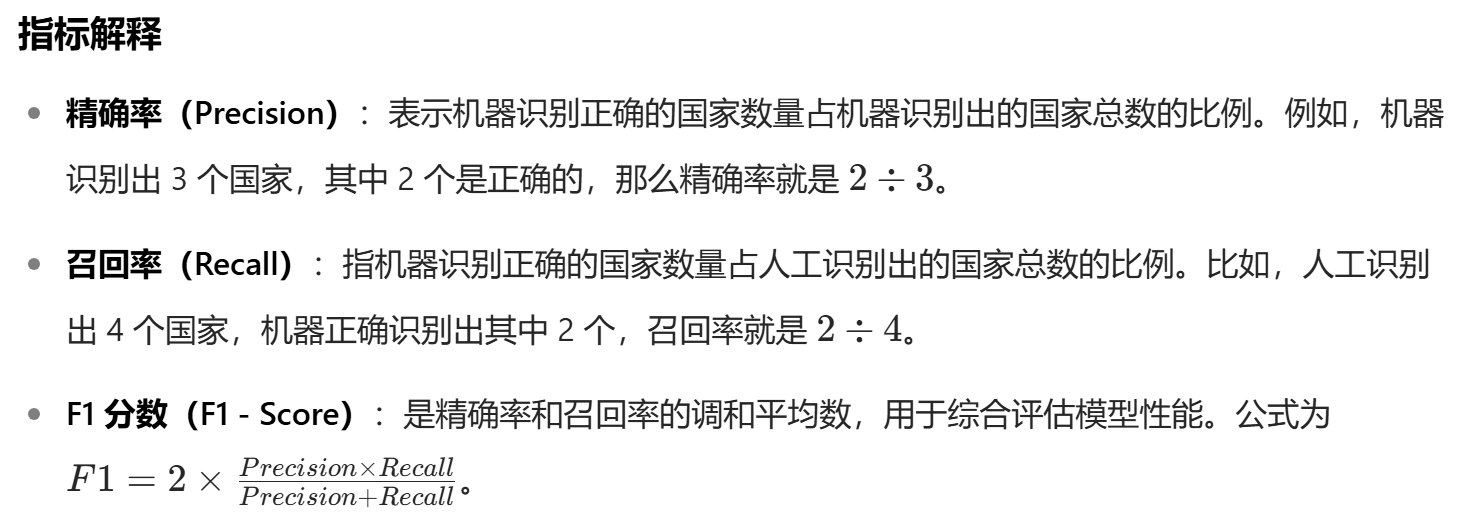

In [163]:
precision = calculate_precision(data['国家识别_gpt'], data['国家识别_人工'])
print(f"国家识别精确率: {precision}")

国家识别精确率: 0.9479166666666666


In [164]:
recall = calculate_recall(data['国家识别_gpt'], data['国家识别_人工'])
print(f"国家识别召回率: {recall}")

国家识别召回率: 0.9479166666666669


In [165]:
f1 = calculate_f1(precision, recall)
print(f"国家识别F1 分数: {f1}")

国家识别F1 分数: 0.9479166666666666


In [166]:
data['sentiment_人工']=data['人工'].apply(lambda x: {key: value for key, value in x.items() if '情感' in key})
data['sentiment_gpt']=data['info'].apply(lambda x: {key: value for key, value in x.items() if '情感' in key})

In [167]:
data['sentiment_人工']=data['sentiment_人工'].apply(lambda x:set(sorted(str(x).replace('{','').replace('}','').replace(' ','').split(','))))
data['sentiment_gpt']=data['sentiment_gpt'].apply(lambda x:set(sorted(str(x).replace('{','').replace('}','').replace(' ','').split(','))))

In [168]:
precision = calculate_precision(data['sentiment_gpt'], data['sentiment_人工'])
print(f"情感识别精确率: {precision}")
precision = calculate_recall(data['sentiment_gpt'], data['sentiment_人工'])
print(f"情感识别召回率: {precision}")
f1 = calculate_f1(precision, recall)
print(f"情感识别F1 分数: {f1}")

情感识别精确率: 0.75375
情感识别召回率: 0.7558333333333332
情感识别F1 分数: 0.8410471182848291


In [169]:
from nltk.metrics.agreement import AnnotationTask

In [170]:
unique_countries_set = set()
raw_data_from_image_df=data[['国家识别_gpt','国家识别_人工']]
for index, row in raw_data_from_image_df.iterrows():
    # 直接用update方法合并集合，因为单元格里的已经是集合了
    unique_countries_set.update(row['国家识别_gpt'])
    unique_countries_set.update(row['国家识别_人工'])

In [171]:
task_data = []
for index, row in raw_data_from_image_df.iterrows():
    for country in unique_countries_set:
        unit_id = f"item_{index}-{country}"
        
        # GPT的标注
        task_data.append(('rater_gpt', unit_id, str(1) if country in row['国家识别_gpt'] else str(0)))
        
        # 人工的标注
        task_data.append(('rater_human', unit_id, str(1) if country in row['国家识别_人工'] else str(0)))

print("数据已成功转换为NLTK所需的格式。")
print("-" * 30)


# --- 步骤 4: 计算并输出 Krippendorff's Alpha ---
task = AnnotationTask(data=task_data)
krippendorff_alpha = task.alpha()

print("✅ 计算完成！")
print(f"Krippendorff's Alpha 信度系数为: {krippendorff_alpha:.4f}")

# --- 步骤 5: 解读结果 ---
alpha_val = krippendorff_alpha
if alpha_val < 0.667:
    print("结果解读：信度较低。评分者之间的一致性不高，可能需要对标注规则进行讨论和澄清。")
elif 0.667 <= alpha_val < 0.8:
    print("结果解读：信度中等/尚可。这在许多研究中被认为是可接受的水平。")
else:
    print("结果解读：信度很高。评分者之间的一致性非常好。")


数据已成功转换为NLTK所需的格式。
------------------------------
✅ 计算完成！
Krippendorff's Alpha 信度系数为: 0.9327
结果解读：信度很高。评分者之间的一致性非常好。


In [172]:
sentimentdf=data[['sentiment_gpt','sentiment_人工']]
sentimentdf.to_excel('temp.xlsx')
df=pd.read_excel('temp.xlsx')

In [173]:
def parse_sentiment_string(s: str) -> dict:
    """
    将格式如 '{"'key1':val1", "'key2':val2"}' 的特定字符串解析为Python字典。
    Handles the specific non-standard format from the input file.
    
    Args:
        s: The input string from the CSV file.
        
    Returns:
        A dictionary of label-value pairs.
    """
    if not isinstance(s, str) or s == '{""}':
        return {}
    # 使用正则表达式查找所有 "'key':value" 格式的配对
    pairs = re.findall(r"'([^']+)':(\d+)", s)
    return {key: int(value) for key, value in pairs}


def calculate_krippendorff_alpha(reliability_data: np.ndarray) -> float:
    """
    计算Krippendorff's Alpha值。
    此函数严格遵循Krippendorff's Alpha的统计公式，适用于名目数据（Nominal）。

    Args:
        reliability_data: 一个NumPy数组，形状为 (units, raters)，即 (分析单元数, 评分者数)。
                          每个单元格是评分者对该单元的评分。
    
    Returns:
        The Krippendorff's alpha coefficient.
    """
    # 确保数据为浮点数以处理可能的缺失值 (NaN)
    reliability_data = np.asarray(reliability_data, dtype=np.float64)

    # --- 1. 构建一致性矩阵 (Coincidence Matrix) ---
    # 获取所有评分类别 (例如, 0 和 1)
    categories = np.unique(reliability_data[~np.isnan(reliability_data)])
    num_categories = len(categories)
    cat_map = {cat: i for i, cat in enumerate(categories)}

    # 初始化一致性矩阵，形状为 (分析单元数, 类别数)
    coincidence_matrix = np.zeros((reliability_data.shape[0], num_categories))
    
    # 填充矩阵：计算每个单元中，每个类别被评了多少次
    for unit_idx, unit_ratings in enumerate(reliability_data):
        for rating in unit_ratings:
            if not np.isnan(rating):
                coincidence_matrix[unit_idx, cat_map[rating]] += 1

    # --- 2. 计算观察到的不一致性 (Observed Disagreement, Do) ---
    # n_u 是每个分析单元获得的总评分数
    n_u = np.sum(coincidence_matrix, axis=1)
    # 只考虑那些至少有两个评分的单元
    valid_units_mask = n_u >= 2
    coincidence_matrix = coincidence_matrix[valid_units_mask]
    n_u = n_u[valid_units_mask]

    # Do 的分子是所有单元内“不一致”配对的总数。
    # 更简单的计算方法是：1 - (所有单元内“一致”配对的总数 / 所有单元内配对的总数)
    # 一致配对数 = sum( n_uk * (n_uk - 1) )，其中n_uk是单元u被评为类别k的次数
    numerator_do = np.sum(coincidence_matrix * (coincidence_matrix - 1))
    # 总配对数 = sum( n_u * (n_u - 1) )
    denominator_do = np.sum(n_u * (n_u - 1))

    if denominator_do == 0:
        return 1.0  # 如果没有可供比较的配对，则认为完全一致
        
    d_o = 1.0 - (numerator_do / denominator_do)

    # --- 3. 计算期望的不一致性 (Expected Disagreement, De) ---
    # n_c 是每个类别在所有数据中出现的总次数
    n_c = np.sum(coincidence_matrix, axis=0)
    # N 是总评分数
    N = np.sum(n_c)

    # De 的计算逻辑与Do类似，但是基于全局的类别分布，代表随机情况下的不一致性
    numerator_de = np.sum(n_c * (n_c - 1))
    denominator_de = N * (N - 1)
    
    if denominator_de == 0:
        return 1.0 # 如果无法计算期望不一致，则认为完全一致

    d_e = 1.0 - (numerator_de / denominator_de)
    
    if d_e == 0:
        # 如果期望不一致为0，意味着所有评分都属于同一类别
        # 此时，观察到的不一致性也必然为0，alpha为 1 - 0/0，定义为1
        return 1.0

    # --- 4. 计算最终的Alpha值 ---
    alpha = 1.0 - (d_o / d_e)
    return alpha


# --- 主程序执行部分 ---

# 1. 加载和解析数据
df['parsed_gpt'] = df['sentiment_gpt'].apply(parse_sentiment_string)
df['parsed_human'] = df['sentiment_人工'].apply(parse_sentiment_string)

# 2. 数据重构：这是处理“多标签”问题的关键
# 找出数据集中所有出现过的情感标签
all_labels = set()
for _, row in df.iterrows():
    all_labels.update(row['parsed_gpt'].keys())
    all_labels.update(row['parsed_human'].keys())

# 将数据从“每个句子一行”转换为“每个句子的每个标签一行”
# 这才是Krippendorff's Alpha需要的“分析单元”
reliability_data_list = []
for _, row in df.iterrows():
    for label in all_labels:
        # 如果某个评分者没有对某个标签打分，我们认为其值为0
        rating_gpt = row['parsed_gpt'].get(label, 0)
        rating_human = row['parsed_human'].get(label, 0)
        reliability_data_list.append([rating_gpt, rating_human])

# 转换为NumPy数组
reliability_matrix = np.array(reliability_data_list)

# 3. 执行计算并打印结果
final_alpha = calculate_krippendorff_alpha(reliability_matrix)

print(f"经验证的Krippendorff's Alpha (多标签) 计算结果为: {final_alpha:.6f}")


经验证的Krippendorff's Alpha (多标签) 计算结果为: 0.768691
